# NEST Simulator | Part 4: Spatially structured networks

Plot configuration

In [36]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

plt.style.use(["science"])
# mpl.rcParams["font.serif"] = ["Times New Roman"]


### 1. Adding spatial information to populations

The generation of strucutred networks is carried out in three steps:
1. **Defining spatiatlly distributed nodes** - assign the layout and neuron types within a layer of our network.
2. **Defining connection specifications**, specify connection parameters. 
3. **Connecting nodes**, apply connection specifications between nodes, equivalent to population-specifity.
4. **Auxillary**, visualize the results of the above steps.

In [37]:
import nest
import matplotlib.pyplot as plt
import numpy as np

nest.ResetKernel()


### 2. Defining spatially distributed nodes

Spatially distributed nodes follows this template:

```python
import nest

positions = ...  # See below for how to define positions
s_nodes = nest.Create(node_model, positions=positions)
```

**Position: On-grid**

Explicitely specify the spacing of the grid with shape (n vs. m rows and columns) and extend (read size, defaults to 1 x 1).

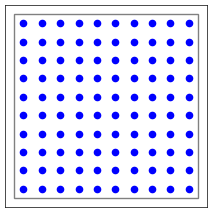

In [38]:
positions = nest.spatial.grid(shape=[10, 10],  # the number of rows and column in this grid ...
                              extent=[2., 2.]  # the size of the grid in mm
                              )
grid_neurons = nest.Create('iaf_psc_alpha', positions=positions)
nest.PlotLayer(grid_neurons)
plt.show()


**Position: Off-grid**

We define a parameter for the placements of the neurons.

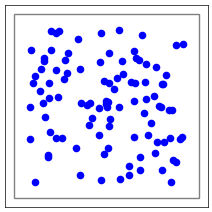

In [39]:
positions = nest.spatial.free(
    nest.random.uniform(min=-0.5, max=0.5),  # using random positions in a uniform distribution
    num_dimensions=2  # have to specify number of dimensions
)
s_nodes = nest.Create('iaf_psc_alpha', 100, positions=positions)

nest.PlotLayer(s_nodes)
plt.show()

### 3. Defining connection profiles

To specify connections between populations of neurons, we specify a connection dictionary such as the ones below:

In [40]:
J = 0.5

# Circular mask, distance-dependent connection probability with gaussian distribution
conn1 = {'rule': 'pairwise_bernoulli',
         'p': nest.spatial_distributions.gaussian(nest.spatial.distance, std=0.2),
         'mask': {'circular': {'radius': 0.75}},
         'allow_autapses': False
         }

# Rectangular mask with non-centered anchor, constant connection probability
conn2 = {'rule': 'pairwise_bernoulli',
         'p': 0.75,
         'mask': {'rectangular': {'lower_left': [-0.5, -0.5], 'upper_right': [0.5, 0.5]},
                 'anchor': [0.5, 0.5]},
         'allow_autapses': False
         }

# Donut mask, linear distance-dependent connection probability
conn3 = {'rule': 'pairwise_bernoulli',
         'p': 1.0 - 0.8 * nest.spatial.distance,
         'mask': {'doughnut': {'inner_radius': 0.1, 'outer_radius': 0.95}},
         }

# Rectangular mask, fixed outdegree, distance-dependent weights from a gaussian distribution,
# distance-dependent delays
conn4 = {'rule': 'fixed_outdegree',
         'outdegree': 40,
         'mask': {'rectangular': {'lower_left': [-0.5, -0.5], 'upper_right': [0.5, 0.5]}},
         'weight': nest.spatial_distributions.gaussian(
             J*nest.spatial.distance, std=0.25),
         'delay': 0.1 + 0.2 * nest.spatial.distance,
         'allow_autapses': False
         }

This allows us to generate structural neuronal networks

<img src="https://nest-simulator.readthedocs.io/en/v3.3/_images/sample2_rectanchor.png" width="400px">


The connection parameters are described in detail [here](https://nest-simulator.readthedocs.io/en/v3.3/tutorials/pynest_tutorial/part_4_spatially_structured_networks.html#:~:text=%3A%20False%0A%20%20%20%20%20%20%20%20%20%7D-,Parameter,Possible%20values,-rule). But it allows neuron parameters to be distance dependent.

### 4. Connecting spatially distributed nodes

In [43]:
ex_pop = nest.Create('iaf_psc_alpha', positions=nest.spatial.grid(shape=[4, 5]))
in_pop = nest.Create('iaf_psc_alpha', positions=nest.spatial.grid(shape=[5, 4]))
conn_dict_ex = {'rule': 'pairwise_bernoulli',
                'p': 1.0,
                'mask': {'circular': {'radius': 0.5}}}

conn_dict_in = {'rule': 'pairwise_bernoulli',
                'p': 1.0,
                'mask': {'circular': {'radius': 0.75}}}

# And now we connect E->I
nest.Connect(ex_pop, in_pop, conn_dict_ex)

nest.Connect(ex_pop, ex_pop, conn_dict_ex)
nest.Connect(in_pop, in_pop, conn_dict_in)
nest.Connect(in_pop, ex_pop, conn_dict_in)

In [46]:
nest.Simulate(100000.0)


Mar 27 15:01:54 NodeManager::prepare_nodes [Info]: 
    Preparing 320 nodes for simulation.

Mar 27 15:01:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 320
    Simulation time (ms): 100000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Mar 27 15:01:58 SimulationManager::run [Info]: 
    Simulation finished.
